<a href="https://colab.research.google.com/github/hypro2/hands-on-LLM-from-colab/blob/main/llama3_2_1b_LoRA_Classifier_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets evaluate peft shap

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, LlamaForSequenceClassification

model_name = 'meta-llama/Llama-3.2-1B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model =  LlamaForSequenceClassification.from_pretrained(model_name, num_labels=5,device_map='auto',torch_dtype="auto")

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer(tokenizer.pad_token)

{'input_ids': [128000, 128001], 'attention_mask': [1, 1]}

In [ ]:
model.config.pad_token_id = 128001

In [ ]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
   

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.score.parameters():
    parameter.requires_grad = True

In [ ]:
from peft import LoraConfig, get_peft_model

# LoRA 설정
lora_config = LoraConfig(
    r=8,  # Low-rank의 차원
    lora_alpha=16,  # LoRA alpha
    lora_dropout=0.1,  # Dropout 비율
    task_type="SEQ_CLS",  # 시퀀스 분류
    target_modules=["q_proj", "k_proj","v_proj","o_proj"],
)
model = get_peft_model(model, lora_config)

In [ ]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
          

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# 1. CSV 파일 읽기
train_df = pd.read_csv("/content/05_sentence.csv")
eval_df = pd.read_csv("/content/05_sentence_eval.csv")
train_df.head()

skey                                                 ti  \
0  4920053002728   waste to energy conversion without co2 emissions   
1  4920052001746  polyimide film for graphite sheet graphite she...   
2  4920052001747  reaction furnace for producing polycrystalline...   
3  4920051002143  compositions and processes for removing heavy ...   
4  4920051002144  method of making nanomaterials from a renewabl...   

                                                  ab  \
0  the invention provides a method for energy ext...   
1  the present disclosure provides a polyimide fi...   
2  a reaction furnace for producing a polycrystal...   
3  processes for removingrecovering heavy metal i...   
4  this patent disclosure includes a process that...   

                                                 clr  \
0  1 a process for obtaining energy from waste wh...   
1  1 a polyimide film prepared from a precursor c...   
2  1 a reaction furnace for producing a polycryst...   
3  1 a process for removing heavy metal ions from...   
4  1 a process for making carbon nanosheet materi...   

                                                 cla                 ipcs  \
0  1 a process for obtaining energy from waste wh...            C10J C01B   
1  1 a polyimide film prepared from a precursor c...  C01B C09K C08J C08G   
2  1 a reaction furnace for producing a polycryst...  C01B C23C B01J C23C   
3  1 a process for removing heavy metal ions from...                 C01B   
4  1 a process for making carbon nanosheet materi...       C01B B82Y C01B   

   label_idx  
0          0  
1          0  
2          0  
3          0  
4          0

In [ ]:
id2label = {0: 'CPC_C01B', 1: 'CPC_C01C', 2: 'CPC_C01D', 3: 'CPC_C01F', 4: 'CPC_C01G'}
model.config.id2label = id2label

label2id = {'CPC_C01B':0 , 'CPC_C01C': 1, 'CPC_C01D':2, 'CPC_C01F':3, 'CPC_C01G':4}
model.config.label2id = label2id

In [ ]:
model.config.label2id

{'CPC_C01B': 0, 'CPC_C01C': 1, 'CPC_C01D': 2, 'CPC_C01F': 3, 'CPC_C01G': 4}

In [ ]:
train_df["document"] = train_df[["ti", "ab",]].fillna("").agg(" ".join, axis=1)
eval_df["document"] = eval_df[["ti", "ab",]].fillna("").agg(" ".join, axis=1)

train_df = train_df[["skey", "document", "label_idx"]].rename(columns={"label_idx": "label"})
eval_df = eval_df[["skey", "document", "label_idx"]].rename(columns={"label_idx": "label"})

In [ ]:
train_df['label'] = train_df['label'].astype('int')
eval_df['label'] = eval_df['label'].astype('int')

In [ ]:
def preprocess_data(example, tokenizer):
    return tokenizer(example["document"], padding=True, truncation=True)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(eval_df)
})

processed_dataset = dataset.map(
    lambda example: preprocess_data(example, tokenizer),
    batched=True,
    remove_columns=["skey", "document"]
).rename_column("label", "labels")

print(dataset)
print(processed_dataset)
print(processed_dataset["train"][0])
print(processed_dataset["test"][0])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['skey', 'document', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['skey', 'document', 'label'],
        num_rows: 200
    })
})
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})
{'labels': 0, 'input_ids': [128000, 86, 5642, 311, 4907, 14747, 2085, 1080, 17, 20748, 279, 28229, 5825, 264, 1749, 369, 4907, 33289, 505, 27512, 323, 9709, 12571, 23914, 279, 1749, 51242, 264, 270, 265, 478, 425, 4611, 299, 398, 14744, 311, 8356, 264, 35784, 14172, 4611, 299, 398, 14744, 6962, 902, 31127, 4861, 4907, 33289, 2085, 28965, 12782, 40589, 1139, 279, 16975, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

longest_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest"
)
longest_dataloader = DataLoader(
    processed_dataset["train"],
    collate_fn=longest_collator,
    batch_size=4,
    shuffle=False
)
longest_iterator = iter(longest_dataloader)
longest_batch = next(longest_iterator)
print("longest 패딩 입력 id shape :", longest_batch["input_ids"].shape)

longest 패딩 입력 id shape : torch.Size([4, 486])


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="text-classification",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=5e-5,
    num_train_epochs=3,
    eval_steps=200,
    logging_steps=200,
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=longest_collator,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["test"]
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: hyeong9647 (hyeong9647-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


KeyboardInterrupt: 

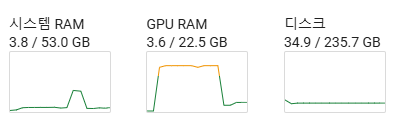

In [ ]:
model.save_pretrained("text-classification-lora")

In [ ]:
import torch

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

text = ""
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs.to(device))
    print(outputs.logits)
    print(outputs.logits.argmax())

tensor([[ 0.0664,  1.1797,  0.6641,  0.5625, -0.2246]], device='cuda:0',
       dtype=torch.bfloat16)
tensor(1, device='cuda:0')


In [ ]:
import evaluate

yhat = trainer.predict(processed_dataset["test"])
predictions = yhat.predictions.argmax(axis=1)
references = yhat.label_ids

metric = evaluate.load("accuracy")
accuracy = metric.compute(predictions=predictions, references=references)
print(accuracy)

{'accuracy': 0.885}


In [ ]:
import transformers
import shap

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
)

explainer = shap.Explainer(pred)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DiffLlamaForSequenceClass

In [ ]:
dataset["test"][0]['document']

'method of producing zeolite film provided is a method of producing a zeolite film continuously and efficiently the method of forming zeolite on a surface of a support is characterized in that the method includes a first step of attaching zeolite fine crystals to a surface of a support a second step of preparing synthetic gel for growing the fine crystals a third step of putting the support and the synthetic gel into a continuous reactor and performing hydrothermal synthesis and a fourth step of cleaning the support on which zeolite has been hydrothermally synthesized and in the third step the temperature pressure and flow of the synthetic gel in the continuous reactor is adjusted the support is moved being immersed in the synthetic gel the reaction time of the hydrothermal synthesis is adjusted by adjusting the time from when the support enters the continuous reactor to when the support exits the continuous reactor'

In [ ]:
shap_values = explainer([dataset["test"][0]['document']])
shap.plots.text(shap_values)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.25s/it]               
